In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import time
import warnings
warnings.filterwarnings('ignore')

import os, sys
currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from helper_functions import *

from datetime import timedelta
import os
import investpy
import yfinance as yf
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# import eikon as ek
# ek.set_app_key('9a249e0411184cf49e553b61a6e76c52d295ec17')

def get_data_alpha(ticker):

    temp_og = get_data(ticker, "yfinance", "")

    today_data = yf.download(ticker, start=str(date.today() - timedelta(days=1)), interval="1m")
    today_data.reset_index(inplace=True)
    today_data.drop(['Adj Close'], axis=1, inplace=True)

    today_time_close = today_data.iloc[-1]["Datetime"]

    temp_og = pd.concat([temp_og, pd.DataFrame([{"Date": pd.Timestamp(year=today_data.iloc[-1]["Datetime"].year,
                                                                      month=today_data.iloc[-1]["Datetime"].month,
                                                                      day=today_data.iloc[-1]["Datetime"].day),\
                                                 "Open": today_data.iloc[-1]["Open"],
                                                 "Close": today_data.iloc[-1]["Close"],
                                                 "High": today_data.iloc[-1]["High"],
                                                 "Low": today_data.iloc[-1]["Low"],
                                                 "Volume": today_data.iloc[-1]["Volume"]}])],axis=0).reset_index().drop(['index'], axis=1)
    temp_og.drop_duplicates(subset="Date",
                            keep='first', inplace=True)
    temp_og = add_fisher(temp_og)
    return temp_og, today_time_close

def select_all_strategies(train_monthsf, datesf, temp_ogf, ticker, save=True):
    inputs =[]
    for date_i in range(len(datesf)-(int(train_monthsf/3)+1)):
        inputs.append([date_i, datesf, temp_ogf, train_monthsf])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results = pool.map(get_strategies_brute_force, inputs)
    finally: # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    res_test_update = [pd.DataFrame(columns=["Lookback", "Low Bound", "High Bound", "AvgWinLoss",\
                                       "Optimization_Years"])] * (len(datesf)-(int(24/3)+1))

    for i in range(len(results)):
        res_test_update[results[i][0]+int((train_monthsf-24)/3)] = pd.concat([res_test_update[results[i][0]],results[i][1].reset_index().drop(['index'], axis=1)], axis=0)

    if save==True:
        with open(f'{ticker}/SelectedStrategies/{ticker}_TrainYrs_{int(train_monthsf/12)}_All_Strategies.pkl','rb') as file:
            res_test = pickle.load(file)
        res_test.append(res_test_update[-1])
        with open(f'{ticker}/SelectedStrategies/{ticker}_TrainYrs_{int(train_monthsf/12)}_All_Strategies.pkl', 'wb') as file:
            pickle.dump(res_test, file)
    return res_test

def select_strategies_from_corr_filter(res_testf2,res_testf4,res_testf8, datesf, temp_ogf, num_opt_periodsf,num_strategiesf, ticker, save=True):
    train_monthsf = 24  #minimum optimization lookback
    res_total = [None]*(len(datesf)-(int(train_monthsf/3)+1))
    for i in range(len(datesf)-(int(train_monthsf/3)+1)):
        if num_opt_periodsf==1:
            res_total[i] = pd.concat([res_testf2[i]], axis = 0)
        if num_opt_periodsf==2:
            res_total[i] = pd.concat([res_testf2[i],res_testf4[i]], axis=0)
        if num_opt_periodsf==3:
            res_total[i] = pd.concat([res_testf2[i],res_testf4[i],res_testf8[i]], axis=0)
        res_total[i] = res_total[i].reset_index().drop(['index'], axis=1)

    ss_test_update = [None]*(len(datesf)-(int(train_monthsf/3)+1))
    res_test_update = [None]*(len(datesf)-(int(train_monthsf/3)+1))
    inputs = []
    for date_i in range(len(datesf)-(int(train_monthsf/3)+1)):
        inputs.append([date_i, datesf, temp_ogf,res_total, num_strategiesf,train_monthsf])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results_filtered = pool.map(corr_sortino_filter, inputs)
    finally: # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    for i in range(len(datesf)-(int(train_monthsf/3)+1)):
        ss_test_update[results_filtered[i][0]] = results_filtered[i][1]
        res_test_update[results_filtered[i][0]] = results_filtered[i][2]

    if save==True:
        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_ss.pkl','rb') as file:
            ss_test = pickle.load(file)
        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_res.pkl','rb') as file:
            res_test = pickle.load(file)

        ss_test.append(ss_test_update[-1])
        res_test.append(res_test_update[-1])

        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_ss.pkl', 'wb') as file:
            pickle.dump(ss_test, file)
        with open(f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{num_opt_periodsf}_Selected_Strategies_res.pkl', 'wb') as file:
            pickle.dump(res_test, file)

    return ss_test, res_test

def SendMail(text_restricted,text_midcap, text_gold, text, printdf_midcap, printdf_gold, assets, ImgFileNameList):
    msg = MIMEMultipart()
    msg['Subject'] = f'NIFTY MIDCAP50 - Strategy Update on Dual Momentum - Alpha & Accelerating Momentum'
    msg['From'] = 'algo_notifications@acsysindia.com'
    msg['Cc'] = 'suprabhashsahu@acsysindia.com' #, aditya@shankar.biz
    msg['To'] = 'algo_notifications@acsysindia.com'

    for ImgFileName in ImgFileNameList:
        with open(ImgFileName, 'rb') as f:
            img_data = f.read()
        image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
        msg.attach(image)

    text_restricted = MIMEText(text_restricted)
    msg.attach(text_restricted)

    text_midcap = MIMEText(text_midcap)
    msg.attach(text_midcap)

    strategies_midcap = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(printdf_midcap.to_html())

    part1 = MIMEText(strategies_midcap, 'html')
    msg.attach(part1)

    text_gold = MIMEText(text_gold)
    msg.attach(text_gold)

    strategies_gold = """\
        <html>
          <head></head>
          <body>
            {0}
          </body>
        </html>
        """.format(printdf_gold.to_html())

    part2 = MIMEText(strategies_gold, 'html')
    msg.attach(part2)

    text = MIMEText(text)
    msg.attach(text)

    assetsprint = """\
            <html>
              <head></head>
              <body>
                {0}
              </body>
            </html>
            """.format(assets.to_html())

    part3 = MIMEText(assetsprint, 'html')
    msg.attach(part3)

    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.ehlo()
    s.starttls()
    s.ehlo()
    s.login('algo_notifications@acsysindia.com', 'esahYah8')
    s.sendmail('algo_notifications@acsysindia.com', ['suprabhashsahu@acsysindia.com', 'algo_notifications@acsysindia.com'], msg.as_string())  #, 'aditya@shankar.biz'
    s.quit()

def signal_print(inp, ticker):
    if inp == 0:
        signal = f"Neutral on {ticker}, Long on Fixed Income"
    else:
        signal = f"Long on {ticker}, Neutral on Fixed Income"
    return signal

def execute_midcap(ticker, number_of_optimization_periods,recalib_months,num_strategies,metric):
    # Download data
    temp_og, today_time_close = get_data_alpha(ticker)

    dates_all_ss = pd.date_range(start=str(temp_og.iloc[1]['Date'] + timedelta(days=365))[:10], end="2024-06-15",
                                 freq=f'3M')
    dates_ss = valid_dates(dates_all_ss)

    print(f"Importing selected strategies: {datetime.now()}")
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_ss.pkl',
            'rb') as file:
        ss_test_imp = pickle.load(file)
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_res.pkl',
            'rb') as file:
        res_test_imp = pickle.load(file)

    res_test = []
    ss_test = []
    dates = []
    for date_i in range(len(dates_ss) - (int(24 / 3) + 1)):
        if (3 * date_i) % recalib_months == 0:
            dates.append(dates_ss[date_i + int(24 / 3)])
            ss_test.append(ss_test_imp[date_i])
            res_test.append(res_test_imp[date_i])

    dates.append(date.today()+timedelta(1))
    date_p = [date_i for date_i in range(len(dates) - 1)][-1]
    print(
        f"Selected Strategies for Testing period beginning: {str(dates[date_p])} and ending: {str(dates[date_p + 1])}")
    print(res_test[date_p])

    print(f"Importing Weights: {datetime.now()}")
    with open(
            f'{ticker}/weights/Results_Ticker{ticker}_LP{number_of_optimization_periods}_Recal{recalib_months}_NS{num_strategies}_M{metric}.pkl',
            'rb') as file:
        weights = pickle.load(file)

    inputs = []
    for date_i in range(len(dates) - 1):
        inputs.append(
            [date_i, dates, temp_og, ss_test, res_test, num_strategies, weights[date_i], recalib_months, dates_ss])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results_backtest = pool.map(backtest_live, inputs)
    finally:  # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    results_final = pd.DataFrame()
    for tt in results_backtest:
        results_final = pd.concat([results_final, tt[0]], axis=0)
    temp_res = results_final

    initial_amount = 2441200
    current_balance = initial_amount
    equity_allocation = 0
    cash_allocation = 0
    portfolio_value = pd.DataFrame()

    units_equity = 0

    for i in range(len(temp_res)):

        signal = temp_res["signal"].iloc[i]

        if signal == 1:
            equity_allocation = current_balance
            cash_allocation = 0
        else:
            equity_allocation = 0
            cash_allocation = current_balance

        if ((temp_res["signal"].iloc[i] == 1) & (temp_res["signal"].shift(1).fillna(0).iloc[i] == 0)):
            units_equity = equity_allocation / temp_res.iloc[i]["Close"]

        if ((temp_res["signal"].iloc[i] == 0) & (temp_res["signal"].shift(1).fillna(1).iloc[i] == 1)):
            units_equity = 0

        if signal == 1:
            equity_allocation = units_equity * temp_res.iloc[i]["Close"]
        cash_allocation = cash_allocation * (1 + 6 / 25200)
        current_balance = equity_allocation + cash_allocation
        portfolio_day = {'Date': temp_res.index[i], 'Signal_backtest': signal, 'units_equity': units_equity,
                         'equity_allocation': equity_allocation, 'cash_allocation': cash_allocation,
                         'Strategy_Return': current_balance}
        portfolio_day = pd.DataFrame([portfolio_day])
        portfolio_day = portfolio_day.set_index("Date")
        portfolio_value = pd.concat([portfolio_value, portfolio_day], axis=0, join="outer")

    temp_res = pd.concat([temp_res, portfolio_value], axis=1, join="inner")
    temp_res["Market_Return"] = (initial_amount / temp_res.iloc[0]["Close"]) * temp_res["Close"]
    temp_res.reset_index(inplace=True)
    temp_res_midcap = temp_res.copy()
    temp_res_midcap.columns = ["Date"] + [column + "_midcap" for column in temp_res_midcap.columns if column != 'Date']

    plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
    plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
    plt.title('Strategy Backtest: midcap Alpha')
    plt.legend(loc=0)
    plt.tight_layout()
    plt.savefig(f"Performance{ticker}.jpg")
    plt.clf()

    text = ""
    text = text + "*"*100 + "\n"
    text = text + "midcap Alpha" + "\n"
    text = text + "Phase-1: Top strategies are ones which maximises the Average Win/Average Loss of the trades made over the lookback period" + "\n"
    text = text + "Top Strategies are selected based on lookbacks of 24 months" + "\n"
    text = text + f"Top Strategies are selected every {recalib_months} months" + "\n"
    text = text + f"Top {num_strategies} strategies are selected" + "\n"
    text = text + f"Strategies selected based on training data from: {str(dates[date_p] - relativedelta(months = 24))[:11]} to: {str(dates[date_p])[:11]} are selected" + "\n"
    text = text + f"Phase-2: Weights of the selected strategies are calculated such that rolling outperformance against benchmark is maximised over a lookback of 24 months "+ "\n"
    text = text + f"Last Recalibrated midcap Alpha on {str(dates[-2])[:11]}" + "\n"
    text = text + f"Recalibrating midcap Alpha on {str(dates[-2] + relativedelta(months = recalib_months))[:11]}" + "\n" + "\n"
    text = text + "Alpha Stats for last 252 trading days:" + "\n"
    text = text + f"Sortino: {np.round(backtest_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Sharpe: {np.round(backtest_sharpe(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling Sortino: {np.round(backtest_rolling_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling CAGR: {np.round(backtest_rolling_cagr(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"MaxDrawup/MaxDrawdown: {np.round(backtest_maxdrawup_by_maxdrawdown(temp_res[-252:], 0, 0), 2)}" + "\n" + "\n"
    text = text + f"Signal at : {str(today_time_close)[:19]}: {signal_print(temp_res.iloc[-1]['signal'],ticker)}" + "\n" f"Signal at Yesterday Close: {signal_print(temp_res.iloc[-2]['signal'],ticker)}" + "\n" f"Signal at Day before Yesterday Close: {signal_print(temp_res.iloc[-3]['signal'],ticker)}" + "\n" + "\n" + "Overall Performance:" + "\n" + f"Portfolio Value: {np.round(temp_res.iloc[-1]['Strategy_Return'], 2)}" + "\n" + "\n"
    text = text + "Selected Strategies: " + "\n" + "\n"
    return temp_og,str(today_time_close)[:19],dates_all_ss,dates_ss,results_backtest[-1][1],temp_res_midcap, text

def execute_gold(ticker, number_of_optimization_periods,recalib_months,num_strategies,metric):

    # Download data
    temp_og, today_time_close = get_data_alpha(ticker)

    dates_all_ss = pd.date_range(start=str(temp_og.iloc[1]['Date'] + timedelta(days=365))[:10],
                                 end="2024-06-15", freq=f'3M')
    dates_ss = valid_dates(dates_all_ss)

    print(f"Importing selected strategies: {datetime.now()}")
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_ss.pkl',
            'rb') as file:
        ss_test_imp = pickle.load(file)
    with open(
            f'{ticker}/SelectedStrategies/{ticker}_OptPeriods_{number_of_optimization_periods}_Selected_Strategies_res.pkl',
            'rb') as file:
        res_test_imp = pickle.load(file)

    res_test = []
    ss_test = []
    dates = []
    for date_i in range(len(dates_ss) - (int(24 / 3) + 1)):
        if (3 * date_i) % recalib_months == 0:
            dates.append(dates_ss[date_i + int(24 / 3)])
            ss_test.append(ss_test_imp[date_i])
            res_test.append(res_test_imp[date_i])

    dates.append(date.today()+timedelta(1))
    date_p = [date_i for date_i in range(len(dates) - 1)][-1]
    print(
        f"Selected Strategies for Testing period beginning: {str(dates[date_p])} and ending: {str(dates[date_p + 1])}")
    print(res_test[date_p])

    print(f"Importing Weights: {datetime.now()}")
    with open(
            f'{ticker}/weights/Results_Ticker{ticker}_LP{number_of_optimization_periods}_Recal{recalib_months}_NS{num_strategies}_M{metric}.pkl',
            'rb') as file:
        weights = pickle.load(file)

    inputs = []
    for date_i in range(len(dates) - 1):
        inputs.append(
            [date_i, dates, temp_og, ss_test, res_test, num_strategies, weights[date_i], recalib_months,
             dates_ss])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        results_backtest = pool.map(backtest_live, inputs)
    finally:  # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    results_final = pd.DataFrame()
    for tt in results_backtest:
        results_final = pd.concat([results_final, tt[0]], axis=0)
    temp_res = results_final

    initial_amount = 2441200
    current_balance = initial_amount
    equity_allocation = 0
    cash_allocation = 0
    portfolio_value = pd.DataFrame()

    units_equity = 0

    for i in range(len(temp_res)):

        signal = temp_res["signal"].iloc[i]

        if signal == 1:
            equity_allocation = current_balance
            cash_allocation = 0
        else:
            equity_allocation = 0
            cash_allocation = current_balance

        if ((temp_res["signal"].iloc[i] == 1) & (temp_res["signal"].shift(1).fillna(0).iloc[i] == 0)):
            units_equity = equity_allocation / temp_res.iloc[i]["Close"]

        if ((temp_res["signal"].iloc[i] == 0) & (temp_res["signal"].shift(1).fillna(1).iloc[i] == 1)):
            units_equity = 0

        if signal == 1:
            equity_allocation = units_equity * temp_res.iloc[i]["Close"]

        cash_allocation = cash_allocation * (1 + 6 / 25200)
        current_balance = equity_allocation + cash_allocation
        portfolio_day = {'Date': temp_res.index[i], 'Signal_backtest': signal, 'units_equity': units_equity,
                         'equity_allocation': equity_allocation, 'cash_allocation': cash_allocation,
                         'Strategy_Return': current_balance}
        portfolio_day = pd.DataFrame([portfolio_day])
        portfolio_day = portfolio_day.set_index("Date")
        portfolio_value = pd.concat([portfolio_value, portfolio_day], axis=0, join="outer")

    temp_res = pd.concat([temp_res, portfolio_value], axis=1, join="inner")
    temp_res["Market_Return"] = (initial_amount / temp_res.iloc[0]["Close"]) * temp_res["Close"]
    temp_res.reset_index(inplace=True)

    temp_res_gold = temp_res.copy()
    temp_res_gold.columns = ["Date"] + [column + "_gold" for column in temp_res_gold.columns if
                                        column != 'Date']

    plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
    plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
    plt.title('Strategy Backtest: gold Alpha')
    plt.legend(loc=0)
    plt.tight_layout()
    plt.savefig(f"Performance{ticker}.jpg")
    plt.clf()

    text = ""
    text = text + "*" * 100 + "\n"
    text = text + "gold Alpha" + "\n"
    text = text + "Phase-1: Top strategies are ones which maximises the Average Win/Average Loss of the trades made over the lookback period" + "\n"
    text = text + "Top Strategies are selected based on lookbacks of 24 and 48 months" + "\n"
    text = text + f"Top Strategies are selected every {recalib_months} months" + "\n"
    text = text + f"Top {num_strategies} strategies are selected" + "\n"
    text = text + f"24-month Lookback Strategies selected based on training data from: {str(dates[date_p] - relativedelta(months=24))[:11]} to: {str(dates[date_p])[:11]} are selected" + "\n"
    text = text + f"48-month Lookback Strategies selected based on training data from: {str(dates[date_p] - relativedelta(months=48))[:11]} to: {str(dates[date_p])[:11]} are selected" + "\n"
    text = text + f"Phase-2: Weights of the selected strategies are calculated such that rolling outperformance against benchmark is maximised over a lookback of 24 months " + "\n"
    text = text + f"Last Recalibrated gold Alpha on {str(dates[-2])[:11]}" + "\n"
    text = text + f"Recalibrating gold Alpha on {str(dates[-2] + relativedelta(months = recalib_months))[:11]}" + "\n" + "\n"
    text = text + "Alpha Stats for last 252 trading days:" + "\n"
    text = text + f"Sortino: {np.round(backtest_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Sharpe: {np.round(backtest_sharpe(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling Sortino: {np.round(backtest_rolling_sortino(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"Rolling CAGR: {np.round(backtest_rolling_cagr(temp_res[-252:], 0, 0), 2)}" + "\n"
    text = text + f"MaxDrawup/MaxDrawdown: {np.round(backtest_maxdrawup_by_maxdrawdown(temp_res[-252:], 0, 0), 2)}" + "\n" + "\n"
    text = text + f"Signal at : {str(today_time_close)[:19]} : {signal_print(temp_res.iloc[-1]['signal'],ticker)}" + "\n" f"Signal at Yesterday Close: {signal_print(temp_res.iloc[-2]['signal'],ticker)}" + "\n" f"Signal at Day before Yesterday Close: {signal_print(temp_res.iloc[-3]['signal'],ticker)}" + "\n" + "\n" + "Overall Performance:" + "\n" + f"Portfolio Value: {np.round(temp_res.iloc[-1]['Strategy_Return'], 2)}" + "\n" + "\n"
    text = text + "Selected Strategies: " + "\n" + "\n"
    return temp_og,str(today_time_close)[:19],dates_all_ss,dates_ss,results_backtest[-1][1],temp_res_gold, text

In [3]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

ticker_midcap = "^NSEMDCP50"
number_of_optimization_periods_midcap = 2
recalib_months_midcap = 12
num_strategies_midcap = 7
metric_midcap = 'maxdrawup_by_maxdrawdown'

ticker_gold = "GOLDBEES.NS"
number_of_optimization_periods_gold = 2
recalib_months_gold = 6
num_strategies_gold = 1
metric_gold = 'outperformance'

text = ""
print(f"Executing: {datetime.now()}")

text_restricted = "Restricted List is : [PGHH, PFIZER]" + "\n"

index = ".NIMDCP50"
with open(f'MIDCAP_CSV_Constituents.pkl', 'rb') as file:
    constituents = pickle.load(file)
constituents_all = []
for i in range(len(constituents)):
    constituents_all = constituents_all + constituents.iloc[i][0]
tickers = list(set(constituents_all))

Executing: 2021-09-03 13:33:50.379334


In [5]:
recalibrating_months = 1
training_period = 24  # 24/48/96
dates_recalibrating = valid_dates(pd.date_range(start="2007-01-01", end="2024-06-15", freq=f'{recalibrating_months}M'))
data_inp = prepare_portfolio_data(tickers, recalibrating_months,"investpy", "india")


In [6]:
data_inp = data_inp[(data_inp["Date"]<"2014-02-28") | (data_inp["Date"]>"2014-03-13")]
data_inp = data_inp[data_inp["Date"]!="2020-11-14"]
data_inp = data_inp[data_inp["Date"]!="2020-11-17"]

In [7]:
with open(f'MIDCAP_RecalibPeriod_{int(1)}.pkl', 'rb') as file:
    assets = pickle.load(file)

temp_og_midcap, signal_time_midcap, dates_all_ss_midcap, dates_ss_midcap, printdf_midcap, temp_res_midcap, text_midcap = execute_midcap(ticker_midcap,number_of_optimization_periods_midcap,recalib_months_midcap,num_strategies_midcap,metric_midcap)


temp_og_gold, signal_time_gold, dates_all_ss_gold, dates_ss_gold, printdf_gold, temp_res_gold, text_gold = execute_gold(ticker_gold,number_of_optimization_periods_gold,recalib_months_gold,num_strategies_gold,metric_gold)

data_inp_backtest = pd.concat([data_inp.set_index('Date'), temp_res_midcap.set_index('Date'), temp_res_gold.set_index('Date')], axis=1, join='inner').reset_index()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Importing selected strategies: 2021-09-03 13:35:19.344573
Selected Strategies for Testing period beginning: 2020-09-30 00:00:00 and ending: 2021-09-04
   Lookback  Low Bound  High Bound  AvgWinLoss  Optimization_Years
0        90        1.0         3.2     1202.00                 4.0
1       310       -3.8        -2.0     1149.00                 2.0
2        50       -4.2        -1.5     1149.00                 2.0
3        70       -5.5         0.0      775.53                 4.0
4        50        4.5         1.5      645.00                 4.0
5       250       -5.8        -3.0      602.38                 4.0
6        50        4.8         0.5      486.20                 4.0
7        70       -7.0        -0.8      435.39                 4.0
8       390        0.2         0.5      382.00                 4.0
9       130       -3.5        -1.0      3

<Figure size 1080x360 with 0 Axes>

In [ ]:
import os

for top_nassets in [8,9,10]:
    for rebalancing_months in [3,6,12,18]:
        for starting_point in range(rebalancing_months):

            if os.path.exists(f"MidcapTests/NA{top_nassets}RM{rebalancing_months}SP{starting_point}.jpg"):
                continue

            dates_rebalancing = []
            assetsb = []
            for date_i in range(len(dates_recalibrating) - (int(training_period / recalibrating_months) + 1)):
                if ((recalibrating_months * date_i) % rebalancing_months == starting_point) & (
                        dates_recalibrating[date_i + int(training_period / recalibrating_months)] >=
                        data_inp_backtest["Date"][0]):
                    dates_rebalancing.append(dates_recalibrating[date_i + int(training_period / recalibrating_months)])
                    assetsb.append(assets[date_i].iloc[:top_nassets])
            dates_rebalancing.append(date.today()+timedelta(1))

            results_final, unit_ticker, unit_gold = backtest_Alpha_AM_Midcap(dates_rebalancing, data_inp_backtest, assetsb)


            bench = yf.download("^NSEMDCP50", start='2007-01-01', end=str(date.today()+timedelta(1)))
            bench = bench.loc[bench["Close"] > 1]
            bench["Return"] = np.log(bench["Close"] / bench["Close"].shift(1))

            results_final["S_Return"] = pd.DataFrame(np.log(results_final["Pvalue"] / results_final["Pvalue"].shift(1)))
            temp_res = pd.concat([results_final, bench["Return"]], join="inner", axis=1)
            temp_res['Market_Return'] = np.exp(temp_res['Return'].expanding().sum())-1
            temp_res['Strategy_Return'] = np.exp(temp_res['S_Return'].expanding().sum())-1
            temp_res['Portfolio Value'] = temp_res['Pvalue']
            temp_res = temp_res.reset_index().rename(columns={'index': "Date"})

            plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
            plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
            plt.title('Strategy Backtest: Dual Momentum')
            plt.legend(loc=0)
            plt.tight_layout()
            #plt.plot()
            plt.savefig(f"MidcapTests/NA{top_nassets}RM{rebalancing_months}SP{starting_point}.jpg")
            plt.clf()


In [8]:
top_nassets = 8
rebalancing_months = 12
starting_point = 10

dates_rebalancing = []
assetsb = []
for date_i in range(len(dates_recalibrating) - (int(training_period / recalibrating_months) + 1)):
    if ((recalibrating_months * date_i) % rebalancing_months == starting_point) & (
            dates_recalibrating[date_i + int(training_period / recalibrating_months)] >=
            data_inp_backtest["Date"][0]):
        dates_rebalancing.append(dates_recalibrating[date_i + int(training_period / recalibrating_months)])
        assetsb.append(assets[date_i].iloc[:top_nassets])
dates_rebalancing.append(date.today()+timedelta(1))

In [9]:
for date_i in range(len(dates_rebalancing)-1):
    print("*"*30)
    print(f"Testing period begins: {dates_rebalancing[date_i]}")
    print("Selected Assets")
    print(assetsb[date_i])
    print(f"Testing period ends: {dates_rebalancing[date_i + 1]}")

******************************
Testing period begins: 2012-11-30 00:00:00
Selected Assets
  Ticker  WtROC0.5    WtROC1    WtROC3    WtROC6    WtROC9   WtROC12  \
0   AMAR  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   
1    ZEE  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   
2   CHLA  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   
3   MMFS  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   
4   CAST  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   
5    FED  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   
6   APLO  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   
7   BLKI  0.144633  0.244043  0.032729  0.221101  0.079301  0.278194   

   Accelerating Momentum  
0              24.425665  
1              12.507918  
2               9.753287  
3               8.959189  
4               7.647608  
5               7.126389  
6               6.182037  
7               5.933445  
Testing period end

[*********************100%***********************]  1 of 1 completed


[]

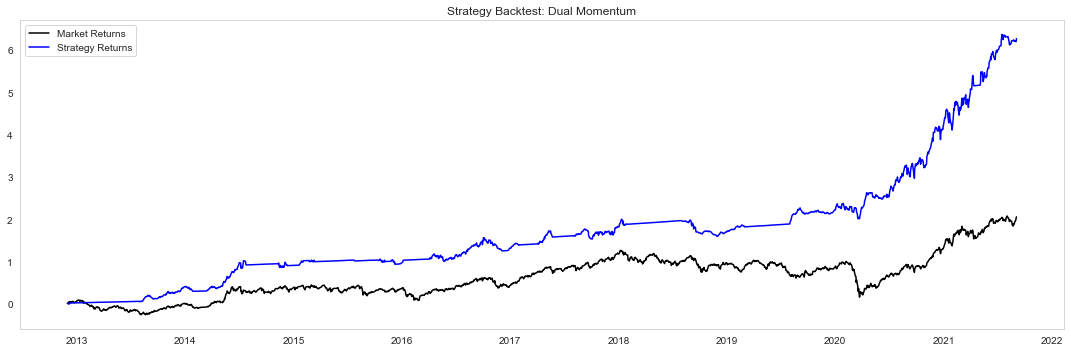

In [10]:
current_balance = 3447436
results_final, unit_ticker, unit_gold = backtest_Alpha_AM_Midcap(dates_rebalancing, data_inp_backtest, assetsb,current_balance)

bench = yf.download("^NSEMDCP50", start='2007-01-01', end=str(date.today()+timedelta(1)))
bench = bench.loc[bench["Close"] > 1]
bench["Return"] = np.log(bench["Close"] / bench["Close"].shift(1))

results_final["S_Return"] = pd.DataFrame(np.log(results_final["Pvalue"] / results_final["Pvalue"].shift(1)))
temp_res = pd.concat([results_final, bench["Return"]], join="inner", axis=1)
temp_res['Market_Return'] = np.exp(temp_res['Return'].expanding().sum())-1
temp_res['Strategy_Return'] = np.exp(temp_res['S_Return'].expanding().sum())-1
temp_res['Portfolio Value'] = temp_res['Pvalue']
temp_res = temp_res.reset_index().rename(columns={'index': "Date"})

plt.plot(temp_res['Date'], temp_res['Market_Return'], color='black', label='Market Returns')
plt.plot(temp_res['Date'], temp_res['Strategy_Return'], color='blue', label='Strategy Returns')
plt.title('Strategy Backtest: Dual Momentum')
plt.legend(loc=0)
plt.tight_layout()
plt.plot()

In [11]:
temp_res['Portfolio Value'].iloc[-1]


25083535.50363321

In [12]:
pd.DataFrame([unit_ticker]).transpose().rename(columns={0:"Units"})

,Units
MINT,1336.101324
ESCO,1372.963987
JNSP,7450.288877
BLKI,1139.773760
VOLT,2373.871151
SRFL,369.956969
COFO,768.119504
TRCE,2120.218795


In [ ]:
temp_res.to_csv("Test.csv")


In [ ]:
text = text + "*" * 100+ "\n"
text = text + "DUAL MOMENTUM STRATEGY"+ "\n"
text = text + f"Recalibrated every {rebalancing_months} months, with training data of {training_period-recalibrating_months} months with a forward return  of {recalibrating_months} month"+ "\n"
text = text + f"The number of assets being selected are: {top_nassets}"
text = text + f"Last Recalibrated Accelerating Momentum on {str(dates_rebalancing[-2])[:11]}" + "\n"
text = text + f"Recalibrating Accelerating Momentum on {str(dates_rebalancing[-2] + relativedelta(months = rebalancing_months))[:11]}" + "\n" + "\n"
text = text + f"Strategies selected based on training data from: {str(dates_rebalancing[-2]- relativedelta(months = training_period))[:11]} to: {str(dates_rebalancing[-2] - relativedelta(months = recalibrating_months))[:11]} are selected" + "\n"
text = text + f"Units and Momentum Values were calculated on {str(dates_rebalancing[-2])[:11]}" + "\n"
text = text + "On Rebalancing Day, if midcap Alpha is long, 100% of the Portolfio are allocated to the stocks below.\nIf midcap Alpha is Neutral and gold Alpha is Long, 50% of the Portfolio is allocated to gold and 50% to Fixed Income.\nIf both Alphas are Neutral, 100% of the Portfolio are allocated to Fixed Income" + "\n"+ "\n"
text = text + "Stats for last 252 trading days:" + "\n"
text = text + f"Sortino: {np.round(backtest_sortino(temp_res[-252:], 0, 0), 2)}"+ "\n"
text = text + f"Sharpe: {np.round(backtest_sharpe(temp_res[-252:], 0, 0), 2)}"+ "\n"
text = text + f"Rolling Sortino: {np.round(backtest_rolling_sortino(temp_res[-252:], 0, 0), 2)}"+ "\n"
text = text + f"Rolling Sharpe: {np.round(backtest_rolling_sharpe(temp_res[-252:], 0, 0), 2)}"+ "\n"
text = text + f"Rolling CAGR: {np.round(backtest_rolling_cagr(temp_res[-252:], 0, 0), 2)}"+ "\n"
text = text + f"Rolling MaxDrawup/MaxDrawdown: {np.round(backtest_maxdrawup_by_maxdrawdown(temp_res[-252:], 0, 0), 2)}"+ "\n"
text = text + f"Rolling Outperformance: {np.round(backtest_outperformance(temp_res[-252:], 0, 0), 2)}"
text = text + "\n" + "\n" + "Overall Performance:" + "\n"
text = text + f" A Portfolio of Rs 0.74072 Cr invested on: {str(dates_rebalancing[0])[:11]} is now valued at: {np.round(temp_res.iloc[-1]['Portfolio Value']/10000000, 4)} Cr." + "\n" + "\n"
text = text + "Selected Assets: " + "\n"
text = text + f"Number of units of gold: {unit_gold}"+ "\n"
# text = f"Signal at : {str(today_time_close)[:19]} : {signal_print(temp_res.iloc[-1]['signal'])}" + "\n" f"Signal at Yesterday Close: {signal_print(temp_res.iloc[-2]['signal'])}" + "\n" f"Signal at Day before Yesterday Close: {signal_print(temp_res.iloc[-3]['signal'])}" + "\n" + "\n" + "Overall Performance:" + "\n" + f"Portfolio Value: {np.round(temp_res.iloc[-1]['Portfolio Value'], 2)}" + "\n" + "\n" + text

SendMail(text_restricted,text_midcap, text_gold, text, printdf_midcap, printdf_gold, pd.concat([assetsb[-1][["Ticker", "Accelerating Momentum"]].set_index("Ticker"), pd.DataFrame([unit_ticker]).transpose().rename(columns={0:"Units"})], axis=1), ["Performance^NSEI.jpg", "Performancegold.jpg", "Performance.jpg"])

#Recalibrating midcap Alpha
if (pd.to_datetime(date.today()-timedelta(days=1)) in dates_all_ss_midcap) & (datetime.now().hour==00) & (datetime.now().minute==1) & (datetime.now().second==00) or recalibrate_today==True:
    print(f"Recalibrating midcap at {datetime.now()}")
    res_test2 = select_all_strategies(24,dates_ss_midcap, temp_og_midcap, ticker_midcap,save=True)
    res_test4 = select_all_strategies(48, dates_ss_midcap, temp_og_midcap, ticker_midcap, save=True)
    # res_test8 = select_all_strategies(96, dates_ss, temp_og, ticker, save=True)
    ss_test_imp, res_test_imp = select_strategies_from_corr_filter(res_test2,res_test4,0, dates_ss_midcap, temp_og_midcap, number_of_optimization_periods_midcap,10, ticker_midcap, save=True)

    res_test = []
    ss_test = []
    dates = []
    for date_i in range(len(dates_ss_midcap) - (int(24 / 3) + 1)):
        if (3 * date_i) % recalib_months_midcap == 0:
            dates.append(dates_ss_midcap[date_i + int(24 / 3)])
            ss_test.append(ss_test_imp[date_i])
            res_test.append(res_test_imp[date_i])

    print(f"Recalibrating Weights: {datetime.now()}")
    inputs = []
    for date_i in range(len(dates)-1):
        inputs.append([date_i, dates, temp_og_midcap, ss_test, res_test, num_strategies_midcap, metric_midcap, recalib_months_midcap,dates_ss_midcap])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        weights_all = pool.map(optimize_weights_live, inputs)
    finally: # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    weights_update = [None]*(len(dates)-1)
    for date_i in range(len(dates)-1):
        weights_update[weights_all[date_i][0]] = weights_all[date_i][1]

    with open(f'{ticker_midcap}/weights/Results_Ticker{ticker_midcap}_LP{number_of_optimization_periods_midcap}_Recal{recalib_months_midcap}_NS{num_strategies_midcap}_M{metric_midcap}.pkl','rb') as file:
        weights = pickle.load(file)

    weights.append(weights_update[-1])

    with open(f'{ticker_midcap}/weights/Results_Ticker{ticker_midcap}_LP{number_of_optimization_periods_midcap}_Recal{recalib_months_midcap}_NS{num_strategies_midcap}_M{metric_midcap}.pkl', 'wb') as file:
        pickle.dump(weights, file)

    print(f"Recalibration for midcap Over at: {datetime.now()}")

# Recalibrating gold Alpha
if (pd.to_datetime(date.today()-timedelta(days=1)) in dates_all_ss_gold) & (datetime.now().hour==00) & (datetime.now().minute==1) & (datetime.now().second==00) or recalibrate_today == True:
    print(f"Recalibrating gold at {datetime.now()}")
    res_test2 = select_all_strategies(24, dates_ss_gold, temp_og_gold, ticker_gold, save=True)
    res_test4 = select_all_strategies(48, dates_ss_gold, temp_og_gold, ticker_gold, save=True)
    # res_test8 = select_all_strategies(96, dates_ss, temp_og, ticker, save=True)
    ss_test_imp, res_test_imp = select_strategies_from_corr_filter(res_test2, res_test4, 0, dates_ss_gold,
                                                                   temp_og_gold,
                                                                   number_of_optimization_periods_gold,
                                                                   10, ticker_gold, save=True)

    res_test = []
    ss_test = []
    dates = []
    for date_i in range(len(dates_ss_gold) - (int(24 / 3) + 1)):
        if (3 * date_i) % recalib_months_gold == 0:
            dates.append(dates_ss_gold[date_i + int(24 / 3)])
            ss_test.append(ss_test_imp[date_i])
            res_test.append(res_test_imp[date_i])

    print(f"Recalibrating Weights: {datetime.now()}")
    inputs = []
    for date_i in range(len(dates) - 1):
        inputs.append(
            [date_i, dates, temp_og_gold, ss_test, res_test, num_strategies_gold, metric_gold,
             recalib_months_gold, dates_ss_gold])
    try:
        pool = multiprocessing.Pool(processes=7, maxtasksperchild=1)
        weights_all = pool.map(optimize_weights_live, inputs)
    finally:  # To make sure processes are closed in the end, even if errors happen
        pool.close()
        pool.join()

    weights_update = [None] * (len(dates) - 1)
    for date_i in range(len(dates) - 1):
        weights_update[weights_all[date_i][0]] = weights_all[date_i][1]

    with open(
            f'{ticker_gold}/weights/Results_Ticker{ticker_gold}_LP{number_of_optimization_periods_gold}_Recal{recalib_months_gold}_NS{num_strategies_gold}_M{metric_gold}.pkl',
            'rb') as file:
        weights = pickle.load(file)

    weights.append(weights_update[-1])

    with open(
            f'{ticker_gold}/weights/Results_Ticker{ticker_gold}_LP{number_of_optimization_periods_gold}_Recal{recalib_months_gold}_NS{num_strategies_gold}_M{metric_gold}.pkl',
            'wb') as file:
        pickle.dump(weights, file)

    print(f"Recalibration for gold Over at: {datetime.now()}")

#Recalibrating AM Constituents
if (pd.to_datetime(date.today()-timedelta(days=1)) == (dates_rebalancing[-2] + relativedelta(months=rebalancing_months))) & (datetime.now().hour==00) & (datetime.now().minute==1) & (datetime.now().second==00) or recalibrate_today == True:
    print(f"Start Recalibrating constituents of BSE at {datetime.now()}")
    index = ".BSESN"
    constituents = get_constituents(index)

    with open(f'BSE_Constituents.pkl', 'wb') as file:
        pickle.dump(constituents, file)

    print(f"End Recalibrating constituents of BSE at {datetime.now()}")

#Recalibrating AM
if (pd.to_datetime(date.today()-timedelta(days=1)) in dates_recalibrating) & (datetime.now().hour==00) & (datetime.now().minute==1) & (datetime.now().second==00) or recalibrate_today == True:
    print(f"Start Recalibrating AM of BSE at {datetime.now()}")
    assets = get_weights_stocks(constituents, top_nassets, recalibrating_months, training_period,dates_recalibrating, data_inp, save=False)
    with open(f'BSE_RecalibPeriod_{int(1)}.pkl', 'wb') as file:
        pickle.dump(assets, file)
    print(f"End Recalibrating AM of BSE at {datetime.now()}")
if datetime.now()<datetime.now().replace(hour=run_hour).replace(minute=run_minute).replace(second=30):
continue

print(f"Sleeping: {datetime.now()}")

time_now = datetime.now()
next_run = datetime.now()
next_run = next_run.replace(day=next_run.day + 1).replace(hour=run_hour).replace(minute=run_minute).replace(second=00)

print(f"Supposed to wake up at: {datetime.now() + timedelta(seconds=(next_run - time_now).seconds - 150)}")
time.sleep((next_run - time_now).seconds-150)
print(f"Woken Up: {datetime.now()}")

In [ ]:
temp_og = get_data("GOLDBEES.NS", "yfinance", "")

In [ ]:
temp_og["Close"].plot()